# Определение эмоционального окраса сообщений в чате FINOPOLIS

__Задача__— создать прототип сервиса, который с помощью машинного обучения сможет определять эмоциональный окрас входящих сообщений и классифицировать их по категориям.

Протестировать его работоспособность на открытых данных, используя датасет с отзывами о фильмах, Large Movie Dataset или Sentiment140 от Стэндфордского университета, а также на реальных кейсах, собранных Почта Банком.

На предыдущем шаге была произведена обработка и очистка датасета __Sentiment140__, теперь на данных можно обучать модели.
Перед нами стоит задача классификации текста на две группы в зависимости от эмоциональной окраски: 0 - negative, 1 - positive.

## 3. Исследование рекуррентных нейронных сетей

Рекуррентные нейронные сети - подкласс неройнных сетей с обратными связями, которые используют предыдущие состояния сети для вычисления текущего. Рекуррентные нейронные сети добавляют память к искуственным нейронным сетям.Рекуррентные нейронные сети показывают результаты лучше других методов в задачах классификации текста.

In [7]:
# импорт библиотек
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
%matplotlib inline 

%tensorflow_version 2.x
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, SimpleRNN 
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, LSTM, Input, Dropout, Embedding
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

### 3.1 Подготовка данных для обучения

In [111]:
train_data = pd.read_parquet('train.parquet')
test_data = pd.read_parquet('test.parquet')

In [114]:
x_train = train_data['text'].values
y_train = train_data['label'].values
x_test = test_data['text'].values
y_test = test_data['label'].values

In [115]:
tokenizer = Tokenizer(num_words=None, filters='!–"—#$%&amp;()*+,-./:;<=>?@[\\]^_`{|}~\t\n\r«»', lower=True, split=' ', char_level=False)
tokenizer.fit_on_texts(x_train)

In [116]:
dist = list(tokenizer.word_counts.items())

data = tokenizer.texts_to_sequences(x_train)
x_train_transformed = pad_sequences(data, maxlen=150)

In [117]:
x_train_transformed

array([[   0,    0,    0, ...,  348,    2,  262],
       [   0,    0,    0, ...,    8,  500,   24],
       [   0,    0,    0, ...,  102,    5,  105],
       ...,
       [   0,    0,    0, ...,    9,    2,  124],
       [   0,    0,    0, ...,   49,   16,    3],
       [   0,    0,    0, ...,    4, 3702,  164]], dtype=int32)

### 3.2 Создание нейронной сети

In [119]:
max_words, input_len = x_train_transformed.shape

In [5]:
model = Sequential()
model.add(Embedding(max_words, 2, input_length=150))

model.add(SimpleRNN(10))
model.add(Dense(1, activation='sigmoid'))

In [6]:
model.compile(optimizer='rmsprop', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

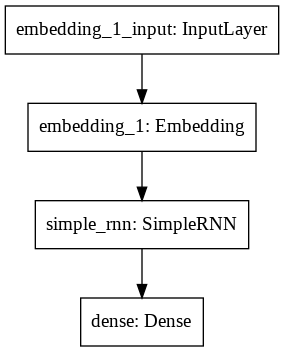

In [8]:
tf.keras.utils.plot_model(model)

### 3.3 Обучение нейронной сети

In [122]:
history = model.fit(x_train_transformed, 
                    y_train, 
                    epochs=25,
                    batch_size=500,
                    validation_split=0.1)

Epoch 1/25
90/90 [==============================] - 14s 142ms/step - loss: 0.6888 - accuracy: 0.5423 - val_loss: 0.6783 - val_accuracy: 0.6186
Epoch 2/25
90/90 [==============================] - 13s 141ms/step - loss: 0.6543 - accuracy: 0.6381 - val_loss: 0.6345 - val_accuracy: 0.6450
Epoch 3/25
90/90 [==============================] - 13s 139ms/step - loss: 0.6032 - accuracy: 0.6937 - val_loss: 0.5897 - val_accuracy: 0.7040
Epoch 4/25
90/90 [==============================] - 12s 138ms/step - loss: 0.5546 - accuracy: 0.7323 - val_loss: 0.5649 - val_accuracy: 0.7126
Epoch 5/25
90/90 [==============================] - 13s 141ms/step - loss: 0.5179 - accuracy: 0.7526 - val_loss: 0.5412 - val_accuracy: 0.7386
Epoch 6/25
90/90 [==============================] - 13s 141ms/step - loss: 0.4918 - accuracy: 0.7667 - val_loss: 0.5304 - val_accuracy: 0.7468
Epoch 7/25
90/90 [==============================] - 13s 139ms/step - loss: 0.4723 - accuracy: 0.7806 - val_loss: 0.5263 - val_accuracy: 0.7536

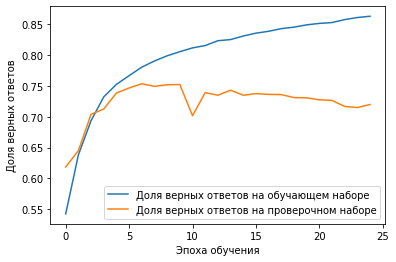

In [123]:
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

### 3.3 Тестирование работы сети на тестовом наборе данных

In [124]:
tokenizer = Tokenizer(num_words=None, filters='!–"—#$%&amp;()*+,-./:;<=>?@[\\]^_`{|}~\t\n\r«»', lower=True, split=' ', char_level=False)
tokenizer.fit_on_texts(x_test)

In [125]:
dist = list(tokenizer.word_counts.items())

data = tokenizer.texts_to_sequences(x_test)
data_pad = pad_sequences(data, maxlen=150)

In [126]:
scores = model.evaluate(data_pad, y_test)

12/12 [==============================] - 0s 18ms/step - loss: 1.1212 - accuracy: 0.5042


К сожалению, результаты полученные с помощью нейронной сети на тестовых данных оказались неудовлетворительными, это связано с несколькими факторами:
 

*   Необходимо использовать более серьезные архитектуры сетей, однако машинные ресурсы для этого ограничены
*   Необходимо более тщательно подбирать параметры сети, а для этого требуется гораздо больше времени

